In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_openml
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sn
from sklearn.datasets import fetch_california_housing
import pymc3 as pm
import arviz as az
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import math

### Machine Learning Assignment Bristol Module

In [12]:
plt.style.use('fivethirtyeight')

In [5]:
mnist = fetch_openml(name='mnist_784')
X = mnist.data

In [6]:
target = mnist.target
label = pd.Series(target).rename("label")

In [7]:
pca = PCA(2)
X_reduced = pca.fit_transform(X)

In [8]:
columns = ["1st_principle", "2nd_principle"]
df = pd.DataFrame(data = X_reduced, index = None, columns = columns) 
df = pd.concat([df, label], axis=1)

<Figure size 432x288 with 0 Axes>

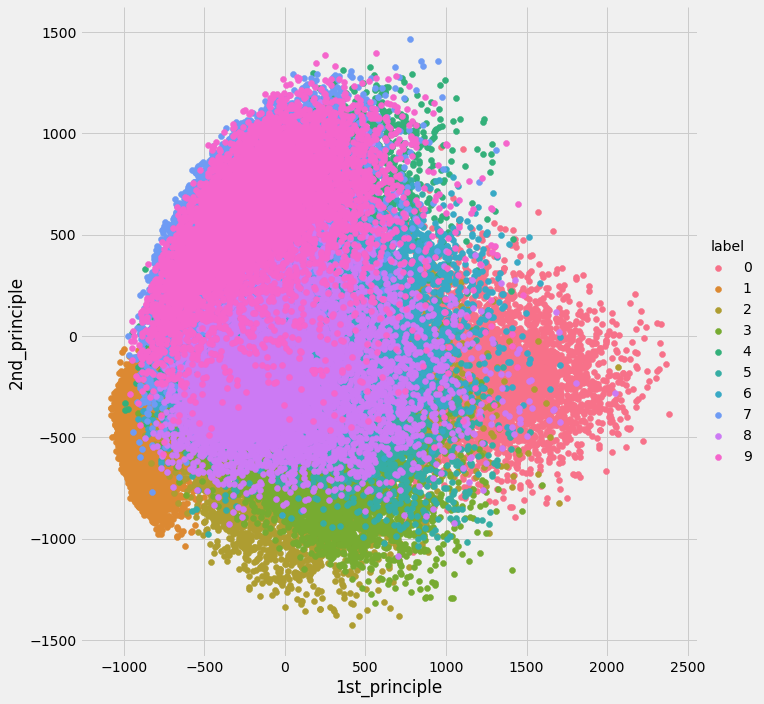

In [17]:
#plotting the 2d data points with seaborn
plt.figure()
sn.FacetGrid(df, hue="label", height=10).map(plt.scatter,"1st_principle","2nd_principle").add_legend()
plt.show()

In [26]:
 class Kmeans:
    def __init__(self, X,y,k):
        self.X = X
        self.y = y
        self.k = k
        self.model = KMeans(self.k, init='random').fit(self.X)
    
    def clusterAssignments(self):
        cluster_assignments = self.model.predict(self.X)
        return cluster_assignments
    
    def centroidLocations(self):
        centroid_locations = self.model.cluster_centers_ 
        return centroid_locations
    
    def centroidClasses(self):
        locations = self.centroidLocations() 
        classes = []
        for location in locations:
            idx = np.where(self.X == location)[0]
            classes.append((self.y[idx])) 
        return classes
    
    def plot_k_means(self):
        plt.figure(figsize=(10, 10))
        plt.viridis() # Set colour map
        plt.scatter(self.X[:, 0], self.X[:, 1], s=20, c=self.clusterAssignments(), alpha=0.8 ) # plot data points 
        plt.scatter(self.centroidLocations()[:, 0], self.centroidLocations()[:,1], s=200, marker='X', c=range(self.k), edgecolors='k')  #plot clusters
        classes = self.centroidClasses()
        plt.show()

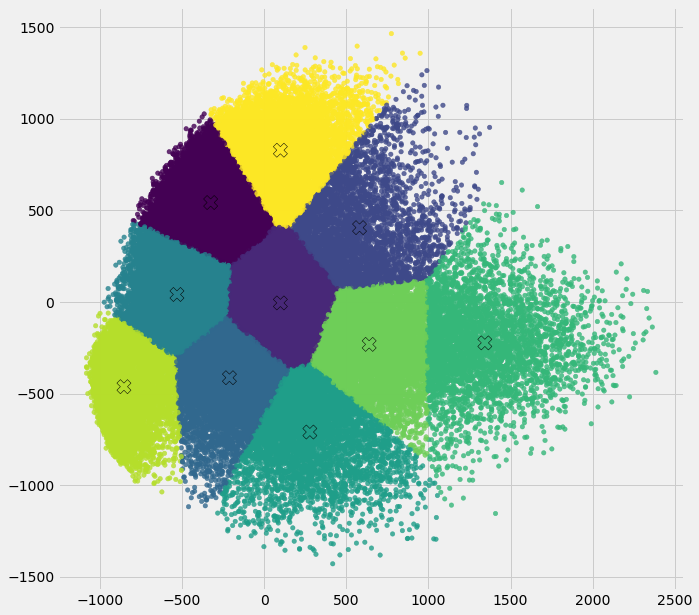

In [27]:
kmeans = Kmeans(X = X_reduced,y = target, k = 10) 
kmeans.plot_k_means()

In [28]:
tuned_params = {'learning_rate_init':np.logspace(-4, -2, 10), "alpha" : np.logspace(-3, -0, 10)}
nn = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes = (28),
                                        activation = 'relu',
                                        solver = 'sgd',
                                        max_iter = 100,
                                        early_stopping = True,
                                        n_iter_no_change = 25,
                                        momentum = 0.5,
                                        random_state = 1),
tuned_params, scoring='accuracy',cv=3, verbose=2, n_jobs = 4)
                                     

In [29]:
nn_pipe = Pipeline([('scalar', StandardScaler()), ('nn', nn)])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.25)

In [31]:
score = nn_pipe.fit(X_train,y_train).score(X_test, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  5.8min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [32]:
print(f"Neural Net score: {round(score,3)}")

Neural Net score: 0.958


In [33]:
nn.best_params_ 

{'learning_rate_init': 0.01, 'alpha': 0.21544346900318823}

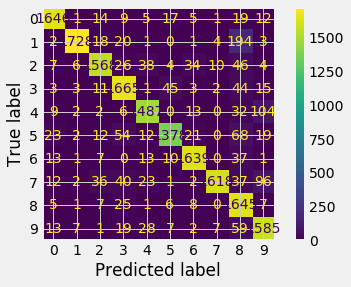

In [34]:
plot_confusion_matrix(nn, X_test, y_test) 

In [35]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    
svm = GridSearchCV(SVC(max_iter = 100),tuned_parameters, cv = 3, n_jobs = 4,scoring='accuracy')
svm_pipe = Pipeline([('scalar', StandardScaler()), ('svm', svm)])

In [36]:
score = svm_pipe.fit(X_train, y_train).score(X_test,y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [37]:
print(f"SVM score: {round(score,3)}")

SVM score: 0.892


In [38]:
svm.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

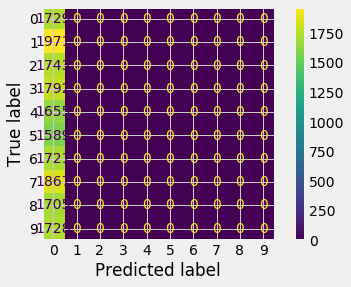

In [39]:
plot_confusion_matrix(svm, X_test, y_test)

In [4]:
 class BayesianLinearRegressor(BaseEstimator, RegressorMixin): 
        """ Bayesian Regression object which uses PyMC3 to
        sample from from a prior using a MCMC to produce a posterior
        from which we randomly sample to obtain model parameters"""
        def __init__(self,num_samples, mu, sd): 
            self.mu = mu
            self.sd = sd
            self.num_samples = num_samples
            
        def fit(self, X, y):
            with pm.Model() as model:
                intercept = pm.Normal('w0', self.mu, self.sd)
                weights = pm.Normal('weights', self.mu, self.sd, shape= X.shape[1])
                sigma = pm.Uniform('sigma', lower=0, upper=20)
                y_est = intercept + pm.math.dot(X, weights)
                likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
                sampler = pm.NUTS()
                trace = pm.sample(self.num_samples,sampler, progressbar=False, cores=4, chains=2, tune=10_000)
            random_index = np.random.randint(self.num_samples)
            self.intercept_ = trace['w0'][random_index] 
            self.coef_ = trace['weights'][random_index]
            return self
        
        def predict(self,X):
            y_pred = self.intercept_ + (X @ self.coef_[:, np.newaxis]) 
            return(y_pred)
        
        def summary(self):
            return az.summary(trace, round_to=2)
        
        def score(self, X_test, y_test): 
            self.y_pred = self.predict(X_test) 
            return(r2_score(self.y_pred, y_test))


In [5]:
 #let's build pipelines for the two regressors:
blr_pipe = Pipeline([('scalar', StandardScaler()), ('blr',BayesianLinearRegressor(num_samples = 100, mu = 0, sd = 1))])

In [6]:
tuned_parameters = {'n_estimators':[20,40,60,80,100], "max_depth" :[20,40,60,80,100]}
rfr = GridSearchCV(RandomForestRegressor(),tuned_parameters, cv = 8, n_jobs =4, scoring='r2' )
rfr_pipe = Pipeline([('scalar', StandardScaler()), ('rfr', rfr)])

In [7]:
cal_housing = fetch_california_housing()
X_df = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
X_df.head(5) #let's have a look at the dataset

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
y = cal_housing.target 
X = X_df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [9]:
score = blr_pipe.fit(X_train, y_train).score(X_test, y_test) 
print(f"Bayesian Regressor score: {round(score,3)}")

<ipython-input-4-f1d80575f467>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(self.num_samples,sampler, progressbar=False, cores=4, chains=2, tune=10_000)
Only 100 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, weights, w0]
Sampling 2 chains for 10_000 tune and 100 draw iterations (20_000 + 200 draws total) took 90 seconds.


Bayesian Regressor score: 0.333


In [15]:
score = rfr_pipe.fit(X_train, y_train).score(X_test, y_test)
print(f"Random Forrest score: {round(score,3)}")

Random Forrest score: 0.797


In [16]:
rfr.best_params_

{'max_depth': 80, 'n_estimators': 100}

In [17]:
estimators = [('br', blr_pipe), ('rfr', rfr_pipe)]
reg = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor()) #let's fit the ensemble and compute score:
score = reg.fit(X_train, y_train).score(X_test, y_test)
print(f"Enemble score: {round(score,3)}")

<ipython-input-4-f1d80575f467>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(self.num_samples,sampler, progressbar=False, cores=4, chains=2, tune=10_000)
Only 100 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, weights, w0]
Sampling 2 chains for 10_000 tune and 100 draw iterations (20_000 + 200 draws total) took 81 seconds.
<ipython-input-4-f1d80575f467>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(self.num_samples,sampler, progressbar=False, cores=4, chains=2, tune=10_000)
Only 100 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, weights, 

Enemble score: 0.764


In [18]:
score_history = []
time_history = []
n_estimators = np.arange(1,9,9)
n=1
while n < 10:
    regr = RandomForestRegressor(n_estimators = n)
    start = time.time()
    regr.fit(X_train,y_train)
    stop = time.time() 
    score_history.append(regr.score(X_test, y_test))
    time_history.append(stop - start)
    n = n+1

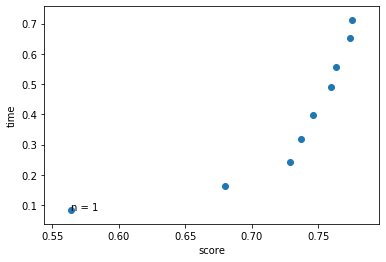

In [19]:
plt.figure()
plt.scatter(score_history, time_history)
for i, txt in enumerate(n_estimators):
    plt.annotate(("n = " + str(txt)), (score_history[i], time_history[i]))
plt.xlabel("score") 
plt.ylabel("time") 
plt.show()